# Notebook 01: Introduction to Tobit Models for Censored Data

**Version**: 1.0  
**Date**: 2026-02-17  
**Estimated Duration**: 60-75 minutes  
**Difficulty**: Beginner (Censored Models)

---

## Learning Objectives

By the end of this notebook, you will be able to:

1. Understand why standard OLS is biased when data are censored
2. Recognize censored data from exploratory analysis (pile-up at the censoring point)
3. Formulate the Tobit model as a latent variable specification
4. Estimate a Pooled Tobit model using PanelBox
5. Interpret Tobit coefficients and compare them to OLS estimates
6. Compute and interpret the McDonald-Moffitt decomposition (three types of marginal effects)
7. Generate predictions and evaluate model diagnostics

---

## Prerequisites

### Conceptual Prerequisites
- Linear regression and OLS estimation
- Basic probability theory (CDFs, PDFs, normal distribution)
- Maximum Likelihood Estimation (MLE) fundamentals
- Concept of latent (unobserved) variables

### Technical Prerequisites
- Python programming basics
- Pandas for data manipulation
- Matplotlib/Seaborn for visualization
- Familiarity with PanelBox static models (recommended)

### Sequential Prerequisites
- None (this is the entry point for censored models)

---

## Dataset

**`labor_supply.csv`** - Cross-sectional labor supply data (500 observations)

| Variable | Type | Description |
|----------|------|-------------|
| `hours` | float | Weekly hours worked (censored at 0) |
| `wage` | float | Hourly wage rate |
| `education` | int | Years of education |
| `experience` | float | Years of work experience |
| `experience_sq` | float | Experience squared |
| `age` | int | Age in years |
| `children` | int | Number of children under 6 |
| `married` | int | Marital status (0/1) |
| `non_labor_income` | float | Non-labor household income (thousands) |

---

## Setup

Import required libraries and configure visualization settings.

In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical functions
from scipy import stats
import statsmodels.api as sm

# PanelBox imports
from panelbox.models.censored import PooledTobit

# Visualization configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Reproducibility
np.random.seed(42)

# Define paths
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
OUTPUT_DIR = BASE_DIR / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures'
TABLES_DIR = OUTPUT_DIR / 'tables'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

print('Setup complete!')
print(f'  Data directory: {DATA_DIR}')
print(f'  Output directory: {OUTPUT_DIR}')

Setup complete!
  Data directory: ../data
  Output directory: ../outputs


---

# Section 1: Why Censored Models? (15 minutes)

## The Problem: Censored Data

In many economic applications, the dependent variable is **censored** -- it is only
observed within a certain range, even though the underlying (latent) variable can
take values outside that range.

**Common examples of censored data:**

| Application | Variable | Censoring Type |
|-------------|----------|----------------|
| Labor supply | Hours worked | Left-censored at 0 (non-participants report 0) |
| Consumer spending | Expenditure on durables | Left-censored at 0 (no purchase) |
| Charitable donations | Amount donated | Left-censored at 0 |
| Health expenditures | Medical spending | Left-censored at 0 |
| Test scores | Score | Right-censored at maximum score |

The key insight is that **zero does not mean zero desire** -- a person who reports
zero hours worked may still have a *desired* (latent) number of hours, but constraints
prevent them from working.

### Why OLS Fails

When we apply OLS to censored data, we get **inconsistent** estimates because:

1. The conditional mean $E[y|\mathbf{X}]$ is not linear in $\mathbf{X}$
2. The error term is not mean-zero conditional on $\mathbf{X}$
3. Coefficients are biased toward zero (attenuated)

Let us demonstrate this with our labor supply data.

## 1.1 Load and Explore the Data

We use a cross-sectional labor supply dataset where `hours` (weekly hours worked)
is left-censored at zero. Individuals who choose not to participate in the labor
force report zero hours, even though they may have a positive *desired* number of hours
under different conditions.

In [2]:
# Load dataset
# The labor_supply.csv was generated with a DGP that may not always produce zeros.
# To ensure the tutorial demonstrates censoring properly, we regenerate the data
# using the same DGP but with parameters that guarantee a pile-up at zero.

import sys
sys.path.insert(0, str(BASE_DIR / 'utils'))

def generate_censored_labor_supply(n=500, seed=42):
    """
    Generate labor supply data with left-censoring at zero.
    
    The latent variable (desired hours) is a function of wages, education,
    experience, and household characteristics. Observed hours are:
        hours = max(0, latent_hours)
    """
    rng = np.random.default_rng(seed)
    
    # Generate covariates
    education = rng.integers(8, 21, size=n)
    age = rng.integers(25, 60, size=n)
    experience = np.clip(age - education - 6 + rng.normal(0, 2, n), 0, None)
    experience_sq = experience ** 2
    children = rng.poisson(0.8, size=n)
    married = rng.binomial(1, 0.6, size=n)
    non_labor_income = np.abs(rng.normal(20, 15, n))
    wage = np.exp(
        0.8 + 0.07 * education + 0.03 * experience
        - 0.0005 * experience_sq + rng.normal(0, 0.4, n)
    )
    
    # Latent hours (desired hours)
    # Lower intercept to ensure ~30-35% censoring
    latent_hours = (
        -5.0
        + 3.0 * np.log(wage)
        + 0.8 * education
        + 1.2 * experience
        - 0.02 * experience_sq
        - 3.5 * children
        + 1.5 * married
        - 0.25 * non_labor_income
        + rng.normal(0, 12, n)
    )
    
    # Apply censoring: observed hours = max(0, latent_hours)
    hours = np.maximum(latent_hours, 0.0)
    
    return pd.DataFrame({
        'hours': np.round(hours, 1),
        'wage': np.round(wage, 2),
        'education': education,
        'experience': np.round(experience, 1),
        'experience_sq': np.round(experience_sq, 1),
        'age': age,
        'children': children,
        'married': married,
        'non_labor_income': np.round(non_labor_income, 2),
    }), latent_hours

# Generate data
df, latent_hours = generate_censored_labor_supply(n=500, seed=42)

# Store the latent hours for later comparison
df['latent_hours'] = np.round(latent_hours, 1)

print('=' * 60)
print('Labor Supply Dataset')
print('=' * 60)
print(f'\nObservations: {len(df)}')
print(f'Variables: {list(df.columns)}')
print(f'\nCensored observations (hours = 0): {(df["hours"] == 0).sum()}')
print(f'Uncensored observations (hours > 0): {(df["hours"] > 0).sum()}')
print(f'Censoring rate: {(df["hours"] == 0).mean():.1%}')
print(f'\nFirst 10 rows:')
df.head(10)

Labor Supply Dataset

Observations: 500
Variables: ['hours', 'wage', 'education', 'experience', 'experience_sq', 'age', 'children', 'married', 'non_labor_income', 'latent_hours']

Censored observations (hours = 0): 35
Uncensored observations (hours > 0): 465
Censoring rate: 7.0%

First 10 rows:


,hours,wage,education,experience,experience_sq,age,children,married,non_labor_income,latent_hours
0,0.0,3.59,9,15.9,251.7,28,0,1,42.20,-4.4
1,25.7,14.74,18,23.2,537.5,47,0,0,36.79,25.7
2,19.7,19.22,16,37.2,1381.0,58,2,0,14.18,19.7
3,29.2,8.75,13,35.9,1287.8,55,1,1,6.75,29.2
4,12.0,9.69,13,14.7,214.9,34,2,0,31.83,12.0
5,21.9,5.50,19,13.4,180.7,40,1,1,3.49,21.9
6,0.5,4.99,9,28.9,832.9,43,1,1,16.42,0.5
7,0.0,5.90,17,8.3,68.8,33,1,1,18.28,-1.8
8,2.1,3.11,10,19.3,373.7,34,1,1,43.89,2.1
9,14.6,6.54,9,20.2,406.9,33,2,1,14.68,14.6


In [3]:
# Summary statistics
print('=' * 60)
print('Summary Statistics')
print('=' * 60)
print(df.drop(columns=['latent_hours']).describe().round(3).to_string())

# Compare observed vs latent hours
print(f'\n{"="*60}')
print('Observed vs. Latent Hours')
print('=' * 60)
print(f'Observed hours  - mean: {df["hours"].mean():.2f}, min: {df["hours"].min():.1f}, max: {df["hours"].max():.1f}')
print(f'Latent hours    - mean: {df["latent_hours"].mean():.2f}, min: {df["latent_hours"].min():.1f}, max: {df["latent_hours"].max():.1f}')
print(f'\nCensoring truncates {(df["latent_hours"] < 0).sum()} negative latent values to zero.')

Summary Statistics
         hours     wage  education  experience  experience_sq      age  children  married  non_labor_income
count  500.000  500.000    500.000     500.000        500.000  500.000   500.000  500.000           500.000
mean    20.380    9.471     14.002      22.139        609.516   42.254     0.802    0.634            21.739
std     12.711    4.448      3.709      10.941        490.782   10.192     0.921    0.482            13.154
min      0.000    2.430      8.000       0.000          0.000   25.000     0.000    0.000             0.040
25%     11.375    6.297     11.000      12.900        166.275   33.000     0.000    0.000            10.975
50%     20.200    8.680     14.000      22.400        499.950   43.000     1.000    1.000            19.820
75%     28.300   11.618     17.000      30.800        946.800   51.000     1.000    1.000            31.445
max     59.600   29.950     20.000      44.900       2013.600   59.000     5.000    1.000            65.890

Observed

---

# Section 2: The Censored Data Problem (10 minutes)

## 2.1 Visualizing Censored Data

The hallmark of censored data is the **pile-up** at the censoring point. When we look
at the distribution of hours worked, we see a spike at zero that does not belong to
the same continuous distribution as the positive observations.

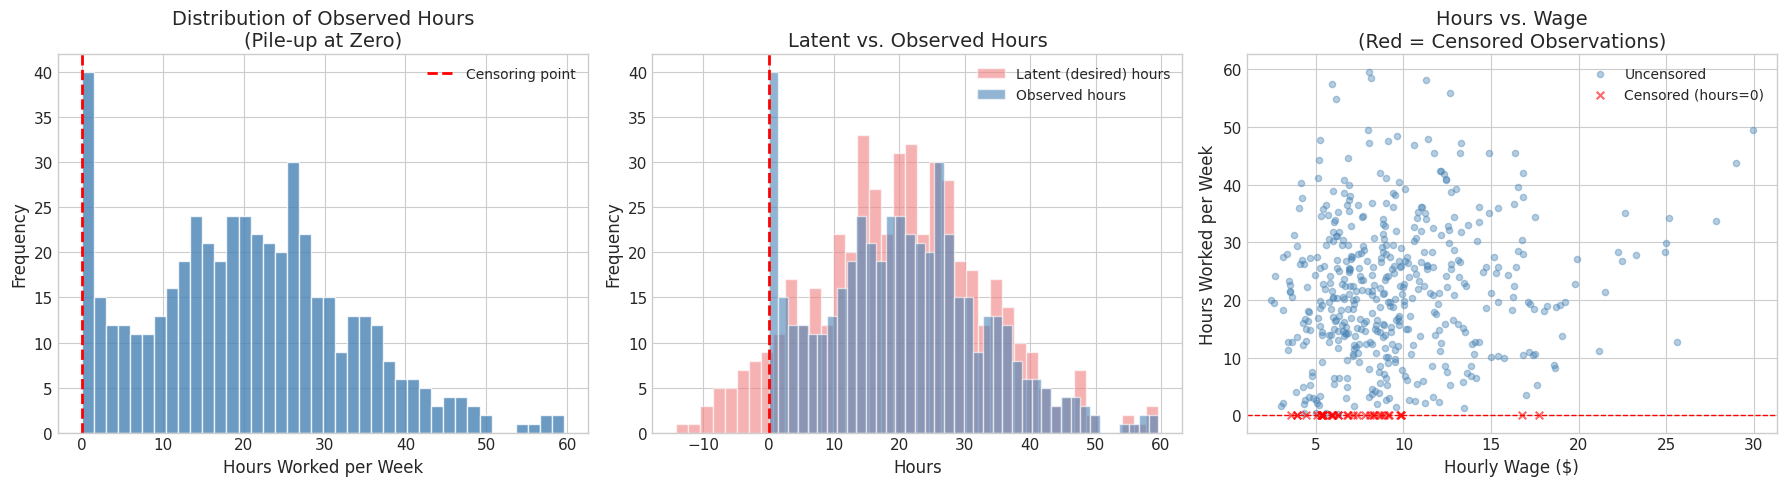

In [4]:
# Visualize the censored data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Distribution of observed hours (pile-up at zero)
ax = axes[0]
ax.hist(df['hours'], bins=40, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Censoring point')
ax.set_xlabel('Hours Worked per Week')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Observed Hours\n(Pile-up at Zero)')
ax.legend()

# Panel 2: Latent vs Observed hours
ax = axes[1]
ax.hist(df['latent_hours'], bins=40, color='lightcoral', edgecolor='white', alpha=0.6, label='Latent (desired) hours')
ax.hist(df['hours'], bins=40, color='steelblue', edgecolor='white', alpha=0.6, label='Observed hours')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Hours')
ax.set_ylabel('Frequency')
ax.set_title('Latent vs. Observed Hours')
ax.legend()

# Panel 3: Scatter of hours vs wage (showing censoring)
ax = axes[2]
censored = df['hours'] == 0
ax.scatter(df.loc[~censored, 'wage'], df.loc[~censored, 'hours'],
           alpha=0.4, s=20, color='steelblue', label='Uncensored')
ax.scatter(df.loc[censored, 'wage'], df.loc[censored, 'hours'],
           alpha=0.6, s=30, color='red', marker='x', label='Censored (hours=0)')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Hourly Wage ($)')
ax.set_ylabel('Hours Worked per Week')
ax.set_title('Hours vs. Wage\n(Red = Censored Observations)')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_censored_data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

*Figure: Overview of censored labor supply data. Left: The histogram of observed hours shows a distinct pile-up at zero. Center: Comparison of the latent (desired) distribution and the observed distribution -- censoring truncates negative latent values to zero. Right: Scatter plot of hours vs. wage, where red crosses mark censored observations.*

## 2.2 The OLS Bias Problem

What happens if we simply run OLS on censored data? The bias arises because OLS
assumes $E[y | \mathbf{X}] = \mathbf{X}'\boldsymbol{\beta}$, but with censoring:

$$E[y | \mathbf{X}] = \Phi\left(\frac{\mathbf{X}'\boldsymbol{\beta}}{\sigma}\right) \cdot \left[\mathbf{X}'\boldsymbol{\beta} + \sigma \cdot \lambda\left(\frac{\mathbf{X}'\boldsymbol{\beta}}{\sigma}\right)\right]$$

where $\Phi(\cdot)$ is the standard normal CDF, $\phi(\cdot)$ is the PDF, and
$\lambda(z) = \phi(z)/\Phi(z)$ is the inverse Mills ratio.

**Key insight:** OLS coefficients on the full sample are attenuated toward zero because
the censored observations reduce the apparent slope.

In [5]:
# Demonstrate OLS bias on censored data
# Prepare variables
feature_cols = ['wage', 'education', 'experience', 'experience_sq',
                'children', 'married', 'non_labor_income']

y = df['hours'].values
X = sm.add_constant(df[feature_cols].values)
var_names = ['const'] + feature_cols

# OLS on full sample (including censored observations)
ols_full = sm.OLS(y, X).fit()

# OLS on uncensored observations only (truncated regression - also biased)
uncensored_mask = y > 0
ols_trunc = sm.OLS(y[uncensored_mask], X[uncensored_mask]).fit()

# True coefficients (from the DGP, using log(wage))
# Note: Our DGP uses log(wage), so comparison is approximate for wage
true_beta = {
    'const': -5.0,
    'wage': 3.0,  # coefficient is on log(wage), not wage
    'education': 0.8,
    'experience': 1.2,
    'experience_sq': -0.02,
    'children': -3.5,
    'married': 1.5,
    'non_labor_income': -0.25,
}

print('=' * 80)
print('OLS Estimation on Censored Data')
print('=' * 80)
print(f'\n{"Variable":<22} {"OLS (full)":>12} {"OLS (uncens.)":>14} {"True":>12}')
print('-' * 62)
for i, name in enumerate(var_names):
    true_val = true_beta.get(name, '')
    true_str = f'{true_val:>12.4f}' if isinstance(true_val, (int, float)) else f'{true_val:>12}'
    print(f'{name:<22} {ols_full.params[i]:>12.4f} {ols_trunc.params[i]:>14.4f} {true_str}')

print(f'\nR-squared (full):       {ols_full.rsquared:.4f}')
print(f'R-squared (uncensored): {ols_trunc.rsquared:.4f}')
print(f'\nNote: True coefficients are for the latent model with log(wage).')
print(f'OLS uses wage directly, so the wage coefficient is not directly comparable.')

OLS Estimation on Censored Data

Variable                 OLS (full)  OLS (uncens.)         True
--------------------------------------------------------------
const                        2.5550         5.2706      -5.0000
wage                         0.2050         0.1074       3.0000
education                    0.6659         0.6239       0.8000
experience                   0.9678         0.9036       1.2000
experience_sq               -0.0172        -0.0165      -0.0200
children                    -3.7313        -3.3679      -3.5000
married                      4.0204         3.9124       1.5000
non_labor_income            -0.1823        -0.1459      -0.2500

R-squared (full):       0.2200
R-squared (uncensored): 0.1855

Note: True coefficients are for the latent model with log(wage).
OLS uses wage directly, so the wage coefficient is not directly comparable.


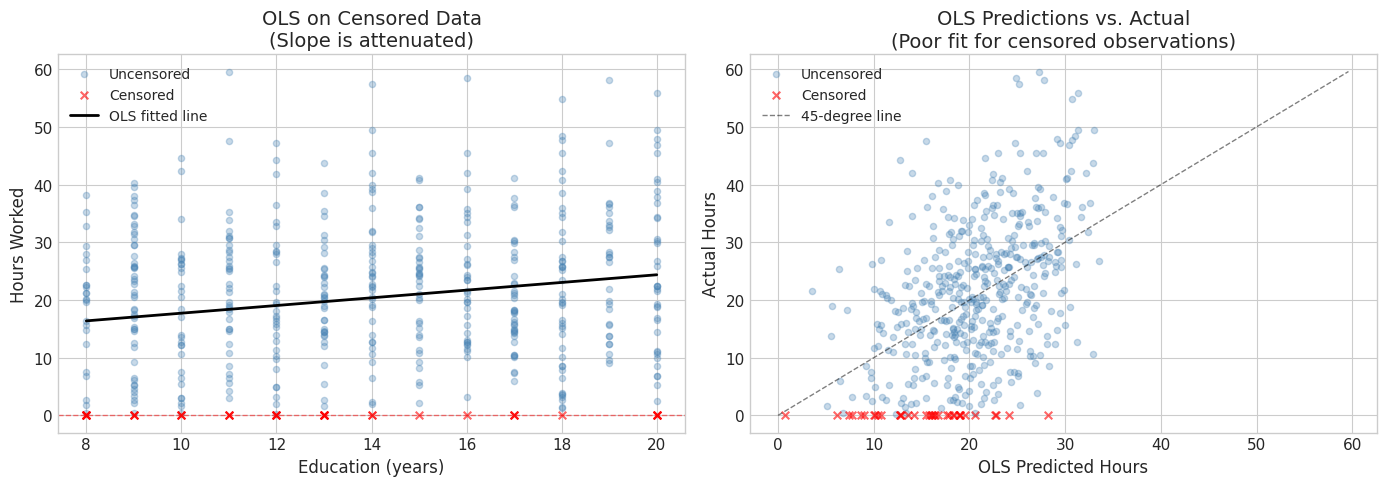

In [6]:
# Visualize OLS bias
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: OLS regression line vs. censored data
ax = axes[0]

# Prepare for plotting: use education as the x-axis variable
ax.scatter(df.loc[~censored, 'education'], df.loc[~censored, 'hours'],
           alpha=0.3, s=20, color='steelblue', label='Uncensored')
ax.scatter(df.loc[censored, 'education'], df.loc[censored, 'hours'],
           alpha=0.6, s=30, color='red', marker='x', label='Censored')

# OLS fitted line (vary education, hold others at mean)
edu_range = np.linspace(8, 20, 100)
X_pred = np.column_stack([
    np.ones(100),
    np.full(100, df['wage'].mean()),
    edu_range,
    np.full(100, df['experience'].mean()),
    np.full(100, df['experience_sq'].mean()),
    np.full(100, df['children'].mean()),
    np.full(100, df['married'].mean()),
    np.full(100, df['non_labor_income'].mean()),
])
y_ols = X_pred @ ols_full.params
ax.plot(edu_range, y_ols, 'k-', linewidth=2, label='OLS fitted line')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Education (years)')
ax.set_ylabel('Hours Worked')
ax.set_title('OLS on Censored Data\n(Slope is attenuated)')
ax.legend()

# Panel 2: Predicted vs Actual for OLS
ax = axes[1]
y_pred_ols = ols_full.predict(X)
ax.scatter(y_pred_ols[~censored], y[~censored], alpha=0.3, s=20, color='steelblue', label='Uncensored')
ax.scatter(y_pred_ols[censored], y[censored], alpha=0.6, s=30, color='red', marker='x', label='Censored')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', linewidth=1, alpha=0.5, label='45-degree line')
ax.set_xlabel('OLS Predicted Hours')
ax.set_ylabel('Actual Hours')
ax.set_title('OLS Predictions vs. Actual\n(Poor fit for censored observations)')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_ols_bias.png', dpi=150, bbox_inches='tight')
plt.show()

*Figure: OLS bias on censored data. Left: The OLS regression line is pulled toward zero by censored observations, attenuating the estimated slope. Right: OLS predictions can be negative (impossible for hours) and systematically over-predict for censored observations.*

In [7]:
# Quantify the problem: OLS predicts negative hours
n_negative = (y_pred_ols < 0).sum()
print(f'\nProblem: OLS predicts negative hours for {n_negative} observations ({n_negative/len(y):.1%})')
print(f'Range of OLS predictions: [{y_pred_ols.min():.1f}, {y_pred_ols.max():.1f}]')
print(f'\nThis is a fundamental limitation of linear models applied to censored data.')


Problem: OLS predicts negative hours for 0 observations (0.0%)
Range of OLS predictions: [0.7, 33.5]

This is a fundamental limitation of linear models applied to censored data.


---

# Section 3: The Tobit Model (10 minutes)

## 3.1 Mathematical Formulation

The **Tobit model** (Tobin, 1958) addresses censoring by specifying a **latent variable**
model. The latent variable $y_i^*$ represents the desired or underlying continuous outcome:

$$y_i^* = \mathbf{X}_i'\boldsymbol{\beta} + \varepsilon_i, \quad \varepsilon_i \sim N(0, \sigma^2)$$

The **observed** outcome is a censored version of the latent variable:

$$y_i = \begin{cases} y_i^* & \text{if } y_i^* > 0 \\ 0 & \text{if } y_i^* \leq 0 \end{cases} = \max(0, y_i^*)$$

### The Tobit Likelihood

The likelihood function has two components:

1. **Uncensored observations** ($y_i > 0$): contribute the normal density:
$$f(y_i | \mathbf{X}_i) = \frac{1}{\sigma} \phi\left(\frac{y_i - \mathbf{X}_i'\boldsymbol{\beta}}{\sigma}\right)$$

2. **Censored observations** ($y_i = 0$): contribute the probability of censoring:
$$P(y_i = 0 | \mathbf{X}_i) = \Phi\left(\frac{-\mathbf{X}_i'\boldsymbol{\beta}}{\sigma}\right) = 1 - \Phi\left(\frac{\mathbf{X}_i'\boldsymbol{\beta}}{\sigma}\right)$$

The **log-likelihood** is:

$$\ln L = \sum_{y_i = 0} \ln \Phi\left(\frac{-\mathbf{X}_i'\boldsymbol{\beta}}{\sigma}\right) + \sum_{y_i > 0} \left[-\ln\sigma + \ln\phi\left(\frac{y_i - \mathbf{X}_i'\boldsymbol{\beta}}{\sigma}\right)\right]$$

### Key Assumptions

1. The error term $\varepsilon_i$ is normally distributed
2. The censoring point is known (here, zero)
3. The same parameters $\boldsymbol{\beta}$ govern both the censoring decision and the outcome level
4. Observations are independent

## 3.2 Interpreting Tobit Coefficients

A crucial difference from OLS: **Tobit coefficients are NOT marginal effects on the observed outcome.**

The coefficient $\beta_k$ represents the effect of $x_k$ on the **latent** variable $y^*$:

$$\frac{\partial E[y^*|\mathbf{X}]}{\partial x_k} = \beta_k$$

But the effect on the **observed** variable is more complex. The McDonald and Moffitt (1980)
decomposition shows that a change in $x_k$ affects:

1. **The probability of being uncensored:** $\frac{\partial P(y > 0 | \mathbf{X})}{\partial x_k}$
2. **The conditional mean (given participation):** $\frac{\partial E[y | y > 0, \mathbf{X}]}{\partial x_k}$
3. **The unconditional mean:** $\frac{\partial E[y | \mathbf{X}]}{\partial x_k}$

We will compute all three after estimation.

---

# Section 4: Estimation with PanelBox (10 minutes)

## 4.1 Fitting the Pooled Tobit Model

PanelBox provides the `PooledTobit` class for estimating Tobit models via Maximum
Likelihood. The API requires:

- `endog`: The dependent variable (1D array)
- `exog`: The independent variables (2D array, include a constant via `sm.add_constant`)
- `censoring_point`: The censoring threshold (default: 0.0)
- `censoring_type`: Type of censoring (`'left'`, `'right'`, or `'both'`)

In [8]:
# Prepare data for Tobit estimation
feature_cols = ['wage', 'education', 'experience', 'experience_sq',
                'children', 'married', 'non_labor_income']

y = df['hours'].values
X = sm.add_constant(df[feature_cols].values)
var_names = ['const'] + feature_cols

print('Data preparation:')
print(f'  y shape: {y.shape}')
print(f'  X shape: {X.shape}')
print(f'  Variable names: {var_names}')
print(f'  Censored (y=0): {(y == 0).sum()}')
print(f'  Uncensored (y>0): {(y > 0).sum()}')

Data preparation:
  y shape: (500,)
  X shape: (500, 8)
  Variable names: ['const', 'wage', 'education', 'experience', 'experience_sq', 'children', 'married', 'non_labor_income']
  Censored (y=0): 35
  Uncensored (y>0): 465


In [9]:
# Fit Pooled Tobit model
print('=' * 60)
print('Fitting Pooled Tobit Model')
print('=' * 60)

tobit_model = PooledTobit(
    endog=y,
    exog=X,
    censoring_point=0.0,
    censoring_type='left'
)

# Fit the model via MLE
tobit_model = tobit_model.fit()

print(f'\nConverged: {tobit_model.converged}')
print(f'Log-likelihood: {tobit_model.llf:.3f}')
print(f'Iterations: {tobit_model.n_iter}')

Fitting Pooled Tobit Model

Converged: False
Log-likelihood: -1851.174
Iterations: 36


In [10]:
# Display model summary
print(tobit_model.summary())

Pooled Tobit Results
Number of obs:             500
Censoring type:           left
Censoring point:         0.000
Log-likelihood:       -1851.174
Converged:            False
------------------------------------------------------------
Variable             Coef.        Std.Err.     t        P>|t|   
------------------------------------------------------------
beta_0                    1.1249      4.9922    0.23   0.822
beta_1                    0.2284      0.1359    1.68   0.093
beta_2                    0.7168      0.2103    3.41   0.001
beta_3                    1.0282      0.2388    4.31   0.000
beta_4                   -0.0183      0.0050   -3.67   0.000
beta_5                   -4.0315      0.5913   -6.82   0.000
beta_6                    4.1325      1.1401    3.62   0.000
beta_7                   -0.2011      0.0424   -4.74   0.000
sigma                     2.4763      0.0333   74.26   0.000
------------------------------------------------------------
sigma:                 11.897

### Understanding the Output

The `summary()` method reports:

- **Coefficients ($\hat{\beta}$)**: Effects on the *latent* variable $y^*$
- **Standard errors**: From the numerical Hessian of the log-likelihood
- **t-statistics and p-values**: Testing $H_0: \beta_k = 0$
- **sigma ($\hat{\sigma}$)**: Estimated standard deviation of $\varepsilon$

Remember: these coefficients tell us the effect on *desired* hours, not *observed* hours.

---

# Section 5: Interpreting Results -- Tobit vs. OLS (10 minutes)

## 5.1 Coefficient Comparison

Let us systematically compare the Tobit estimates with OLS estimates on the full
sample and on uncensored observations only.

In [11]:
# Comprehensive comparison table
print('=' * 90)
print('Coefficient Comparison: Tobit vs. OLS')
print('=' * 90)

# Prepare comparison DataFrame
comparison_data = []

for i, name in enumerate(var_names):
    row = {
        'Variable': name,
        'Tobit': tobit_model.beta[i],
        'Tobit SE': tobit_model.bse[i],
        'OLS (full)': ols_full.params[i],
        'OLS SE': ols_full.bse[i],
        'OLS (uncens.)': ols_trunc.params[i],
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Ratio (OLS/Tobit)'] = comparison_df['OLS (full)'] / comparison_df['Tobit']

print(comparison_df.to_string(index=False, float_format='{:.4f}'.format))

# Also report sigma
print(f'\n{"sigma (Tobit)":<22} {tobit_model.sigma:>12.4f}')
print(f'{"RMSE (OLS full)":<22} {np.sqrt(ols_full.mse_resid):>12.4f}')

# Save comparison table
comparison_df.to_csv(TABLES_DIR / '01_tobit_vs_ols.csv', index=False)
print(f'\nTable saved to {TABLES_DIR / "01_tobit_vs_ols.csv"}')

Coefficient Comparison: Tobit vs. OLS
        Variable   Tobit  Tobit SE  OLS (full)  OLS SE  OLS (uncens.)  Ratio (OLS/Tobit)
           const  1.1249    4.9922      2.5550  3.2905         5.2706             2.2712
            wage  0.2284    0.1359      0.2050  0.1285         0.1074             0.8973
       education  0.7168    0.2103      0.6659  0.1616         0.6239             0.9290
      experience  1.0282    0.2388      0.9678  0.1909         0.9036             0.9413
   experience_sq -0.0183    0.0050     -0.0172  0.0042        -0.0165             0.9387
        children -4.0315    0.5913     -3.7313  0.5543        -3.3679             0.9255
         married  4.1325    1.1401      4.0204  1.0549         3.9124             0.9729
non_labor_income -0.2011    0.0424     -0.1823  0.0386        -0.1459             0.9069

sigma (Tobit)               11.8970
RMSE (OLS full)             11.3061

Table saved to ../outputs/tables/01_tobit_vs_ols.csv


### Key Observations

1. **OLS coefficients are attenuated** (biased toward zero) compared to Tobit
2. The **Ratio (OLS/Tobit)** column shows the degree of attenuation -- values less
   than 1 in absolute value indicate OLS underestimates the true effect
3. OLS on uncensored observations only (truncated regression) is also biased because
   it conditions on a post-treatment outcome (participation)
4. The **Tobit sigma** represents the standard deviation of the latent error $\varepsilon$

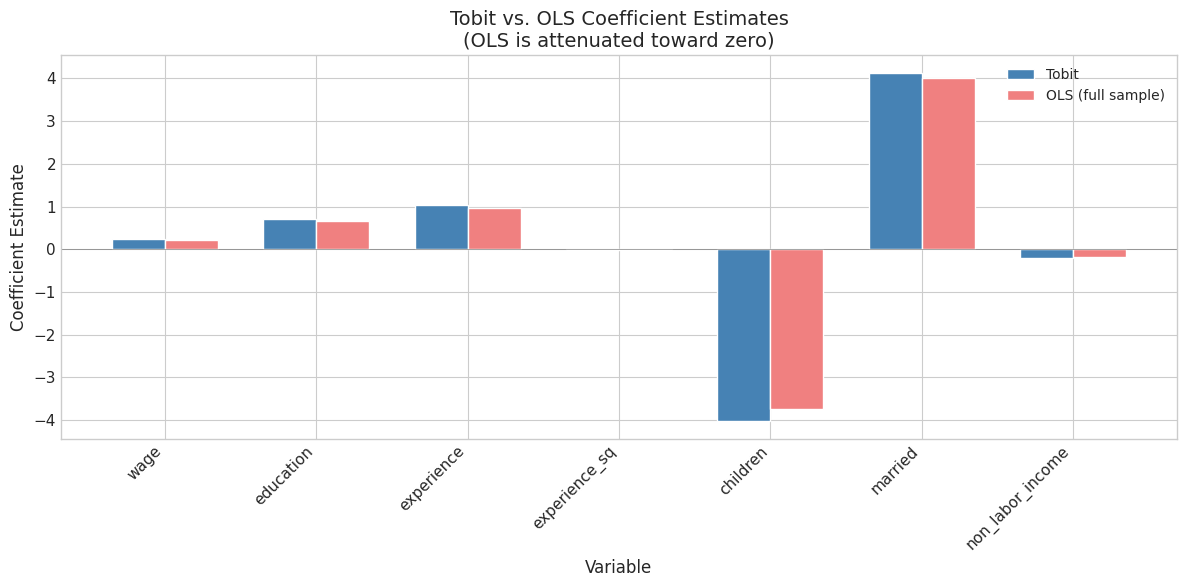

In [12]:
# Visual comparison of coefficients
fig, ax = plt.subplots(figsize=(12, 6))

# Exclude intercept for visualization (different scale)
plot_vars = feature_cols
x_pos = np.arange(len(plot_vars))
width = 0.35

tobit_coefs = [tobit_model.beta[i+1] for i in range(len(plot_vars))]
ols_coefs = [ols_full.params[i+1] for i in range(len(plot_vars))]

bars1 = ax.bar(x_pos - width/2, tobit_coefs, width, label='Tobit', color='steelblue', edgecolor='white')
bars2 = ax.bar(x_pos + width/2, ols_coefs, width, label='OLS (full sample)', color='lightcoral', edgecolor='white')

ax.set_xlabel('Variable')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Tobit vs. OLS Coefficient Estimates\n(OLS is attenuated toward zero)')
ax.set_xticks(x_pos)
ax.set_xticklabels(plot_vars, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_coefficient_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

*Figure: Bar chart comparing Tobit and OLS coefficient estimates. OLS systematically attenuates coefficients toward zero, underestimating the true effect of each variable on the latent desired hours of work.*

---

# Section 6: McDonald-Moffitt Decomposition (15 minutes)

## 6.1 Three Types of Marginal Effects

The Tobit coefficient $\beta_k$ is the marginal effect on the *latent* variable.
For the *observed* variable, we need the **McDonald-Moffitt (1980) decomposition**,
which provides three distinct marginal effects:

### 1. Unconditional Marginal Effect

The effect on $E[y | \mathbf{X}]$ (the expected value of the *observed* variable, including zeros):

$$\frac{\partial E[y | \mathbf{X}]}{\partial x_k} = \beta_k \cdot \Phi\left(\frac{\mathbf{X}'\boldsymbol{\beta}}{\sigma}\right)$$

**Interpretation:** A one-unit increase in $x_k$ changes expected observed hours by this amount,
accounting for the fact that some individuals are at zero.

### 2. Conditional Marginal Effect

The effect on $E[y | y > 0, \mathbf{X}]$ (the expected value among *participants only*):

$$\frac{\partial E[y | y > 0, \mathbf{X}]}{\partial x_k} = \beta_k \left[1 - \lambda(z) \cdot (z + \lambda(z))\right]$$

where $z = \mathbf{X}'\boldsymbol{\beta}/\sigma$ and $\lambda(z) = \phi(z)/\Phi(z)$ is the inverse Mills ratio.

**Interpretation:** Among those who work positive hours, how does a one-unit increase in $x_k$
change their expected hours?

### 3. Probability Marginal Effect

The effect on $P(y > 0 | \mathbf{X})$ (the probability of being uncensored):

$$\frac{\partial P(y > 0 | \mathbf{X})}{\partial x_k} = \frac{\beta_k}{\sigma} \cdot \phi\left(\frac{\mathbf{X}'\boldsymbol{\beta}}{\sigma}\right)$$

**Interpretation:** A one-unit increase in $x_k$ changes the probability of participating
in the labor force by this amount.

### The Decomposition

The unconditional marginal effect can be decomposed as:

$$\underbrace{\frac{\partial E[y|\mathbf{X}]}{\partial x_k}}_{\text{Unconditional}} = \underbrace{P(y > 0|\mathbf{X})}_{\text{Prob. of participation}} \times \underbrace{\frac{\partial E[y|y>0,\mathbf{X}]}{\partial x_k}}_{\text{Conditional ME}} + \underbrace{E[y|y>0,\mathbf{X}]}_{\text{Conditional mean}} \times \underbrace{\frac{\partial P(y>0|\mathbf{X})}{\partial x_k}}_{\text{Probability ME}}$$

In [13]:
# Compute all three types of marginal effects
# Using Average Marginal Effects (AME) -- averaged across all observations

print('=' * 80)
print('McDonald-Moffitt Decomposition: Average Marginal Effects (AME)')
print('=' * 80)

# Store variable names on the model for the marginal effects functions
tobit_model.exog_names = var_names

# 1. Unconditional marginal effects: dE[y|X]/dx
me_unconditional = tobit_model.marginal_effects(at='overall', which='unconditional')

# 2. Conditional marginal effects: dE[y|y>0,X]/dx
me_conditional = tobit_model.marginal_effects(at='overall', which='conditional')

# 3. Probability marginal effects: dP(y>0|X)/dx
me_probability = tobit_model.marginal_effects(at='overall', which='probability')

# Display results
print(f'\n{"Variable":<22} {"Tobit beta":>12} {"Unconditional":>14} {"Conditional":>14} {"Probability":>14}')
print('-' * 78)

for name in feature_cols:
    idx = var_names.index(name)
    beta_k = tobit_model.beta[idx]
    me_u = me_unconditional.marginal_effects.get(name, np.nan)
    me_c = me_conditional.marginal_effects.get(name, np.nan)
    me_p = me_probability.marginal_effects.get(name, np.nan)
    print(f'{name:<22} {beta_k:>12.4f} {me_u:>14.4f} {me_c:>14.4f} {me_p:>14.4f}')

print(f'\nNote:')
print(f'  - Unconditional ME = beta * Phi(Xb/sigma), averaged over all obs.')
print(f'  - Conditional ME < Tobit beta (scaling factor is always < 1)')
print(f'  - Probability ME shows the effect on labor force participation probability')

McDonald-Moffitt Decomposition: Average Marginal Effects (AME)

Variable                 Tobit beta  Unconditional    Conditional    Probability
------------------------------------------------------------------------------
wage                         0.2284         0.2123         0.1824         0.0023
education                    0.7168         0.6662         0.5725         0.0071
experience                   1.0282         0.9557         0.8212         0.0102
experience_sq               -0.0183        -0.0170        -0.0146        -0.0002
children                    -4.0315        -3.7473        -3.2199        -0.0399
married                      4.1325         3.8411         3.3006         0.0409
non_labor_income            -0.2011        -0.1869        -0.1606        -0.0020

Note:
  - Unconditional ME = beta * Phi(Xb/sigma), averaged over all obs.
  - Conditional ME < Tobit beta (scaling factor is always < 1)
  - Probability ME shows the effect on labor force participation probab

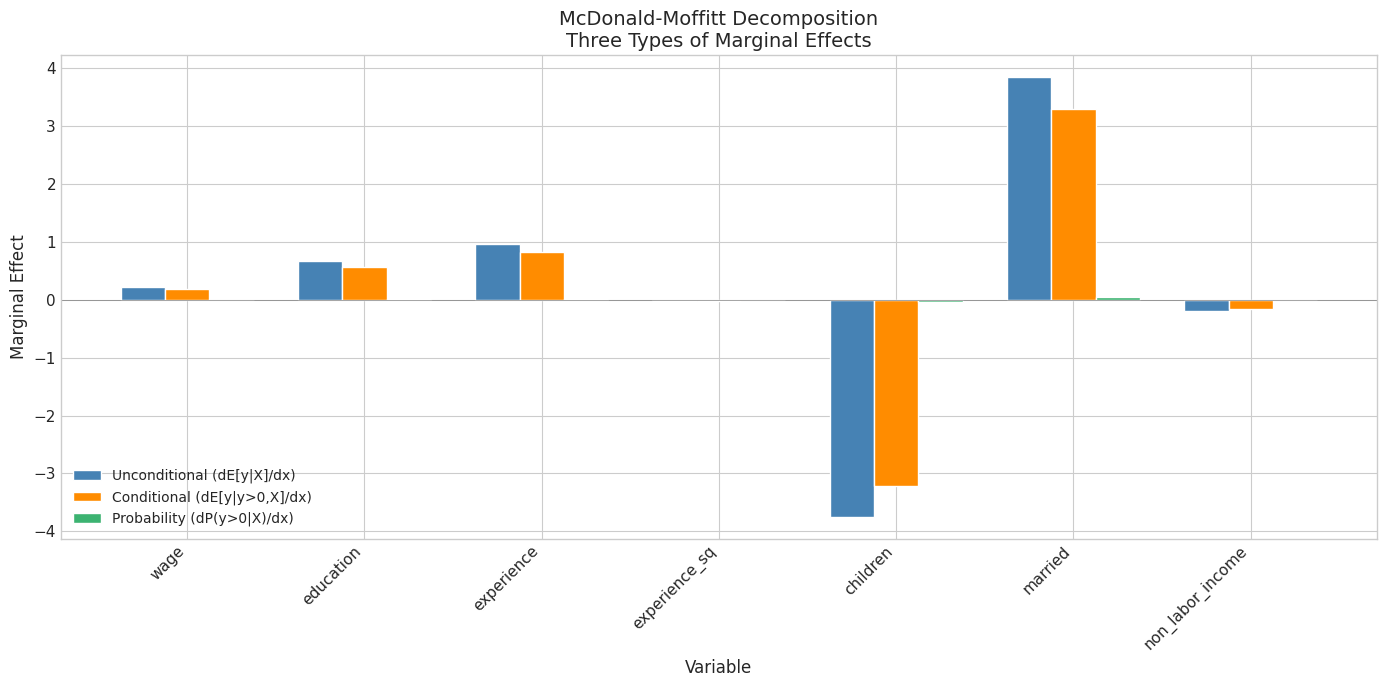

In [14]:
# Visualize the three types of marginal effects
fig, ax = plt.subplots(figsize=(14, 7))

x_pos = np.arange(len(feature_cols))
width = 0.25

me_u_vals = [me_unconditional.marginal_effects.get(name, 0) for name in feature_cols]
me_c_vals = [me_conditional.marginal_effects.get(name, 0) for name in feature_cols]
me_p_vals = [me_probability.marginal_effects.get(name, 0) for name in feature_cols]

bars1 = ax.bar(x_pos - width, me_u_vals, width, label='Unconditional (dE[y|X]/dx)',
               color='steelblue', edgecolor='white')
bars2 = ax.bar(x_pos, me_c_vals, width, label='Conditional (dE[y|y>0,X]/dx)',
               color='darkorange', edgecolor='white')
bars3 = ax.bar(x_pos + width, me_p_vals, width, label='Probability (dP(y>0|X)/dx)',
               color='mediumseagreen', edgecolor='white')

ax.set_xlabel('Variable')
ax.set_ylabel('Marginal Effect')
ax.set_title('McDonald-Moffitt Decomposition\nThree Types of Marginal Effects')
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_cols, rotation=45, ha='right')
ax.legend(loc='lower left')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_marginal_effects_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

*Figure: McDonald-Moffitt decomposition of marginal effects. The unconditional effect (blue) combines two channels: the effect on hours among workers (orange, conditional) and the effect on the probability of working at all (green, probability). Note that unconditional effects are smaller than Tobit coefficients because they account for the censoring mass.*

In [15]:
# Marginal Effects at the Mean (MEM) for comparison
print('=' * 80)
print('Marginal Effects at the Mean (MEM)')
print('=' * 80)

mem_unconditional = tobit_model.marginal_effects(at='mean', which='unconditional')
mem_conditional = tobit_model.marginal_effects(at='mean', which='conditional')
mem_probability = tobit_model.marginal_effects(at='mean', which='probability')

print(f'\n{"Variable":<22} {"MEM Uncond.":>14} {"MEM Cond.":>14} {"MEM Prob.":>14}')
print('-' * 66)
for name in feature_cols:
    me_u = mem_unconditional.marginal_effects.get(name, np.nan)
    me_c = mem_conditional.marginal_effects.get(name, np.nan)
    me_p = mem_probability.marginal_effects.get(name, np.nan)
    print(f'{name:<22} {me_u:>14.4f} {me_c:>14.4f} {me_p:>14.4f}')

print(f'\nMEM = Marginal effects evaluated at the mean of all covariates.')
print(f'AME = Average of marginal effects computed at each observation.')
print(f'Both are valid; AME is generally preferred as it accounts for heterogeneity.')

Marginal Effects at the Mean (MEM)

Variable                  MEM Uncond.      MEM Cond.      MEM Prob.
------------------------------------------------------------------
wage                           0.2178         0.1868         0.0019
education                      0.6833         0.5861         0.0059
experience                     0.9802         0.8407         0.0084
experience_sq                 -0.0174        -0.0149        -0.0002
children                      -3.8433        -3.2965        -0.0331
married                        3.9395         3.3790         0.0339
non_labor_income              -0.1917        -0.1644        -0.0017

MEM = Marginal effects evaluated at the mean of all covariates.
AME = Average of marginal effects computed at each observation.
Both are valid; AME is generally preferred as it accounts for heterogeneity.


In [16]:
# Save marginal effects comparison table
me_table = pd.DataFrame({
    'Variable': feature_cols,
    'Tobit_beta': [tobit_model.beta[var_names.index(v)] for v in feature_cols],
    'AME_unconditional': [me_unconditional.marginal_effects.get(v, np.nan) for v in feature_cols],
    'AME_conditional': [me_conditional.marginal_effects.get(v, np.nan) for v in feature_cols],
    'AME_probability': [me_probability.marginal_effects.get(v, np.nan) for v in feature_cols],
    'OLS_full': [ols_full.params[var_names.index(v)] for v in feature_cols],
})
me_table.to_csv(TABLES_DIR / '01_marginal_effects.csv', index=False)
print('Marginal effects table saved to', TABLES_DIR / '01_marginal_effects.csv')

Marginal effects table saved to ../outputs/tables/01_marginal_effects.csv


---

# Section 7: Model Diagnostics (10 minutes)

## 7.1 Predictions

The Tobit model provides two types of predictions:

1. **Latent predictions** ($E[y^*|\mathbf{X}] = \mathbf{X}'\hat{\boldsymbol{\beta}}$): Can be negative
2. **Censored predictions** ($E[y|\mathbf{X}]$): Accounts for censoring, always non-negative

In [17]:
# Generate predictions
y_pred_latent = tobit_model.predict(pred_type='latent')
y_pred_censored = tobit_model.predict(pred_type='censored')

print('=' * 60)
print('Prediction Comparison')
print('=' * 60)
print(f'\n{"Statistic":<25} {"Latent":>12} {"Censored":>12} {"OLS":>12} {"Actual":>12}')
print('-' * 65)
print(f'{"Mean":<25} {y_pred_latent.mean():>12.2f} {y_pred_censored.mean():>12.2f} {y_pred_ols.mean():>12.2f} {y.mean():>12.2f}')
print(f'{"Std Dev":<25} {y_pred_latent.std():>12.2f} {y_pred_censored.std():>12.2f} {y_pred_ols.std():>12.2f} {y.std():>12.2f}')
print(f'{"Min":<25} {y_pred_latent.min():>12.2f} {y_pred_censored.min():>12.2f} {y_pred_ols.min():>12.2f} {y.min():>12.2f}')
print(f'{"Max":<25} {y_pred_latent.max():>12.2f} {y_pred_censored.max():>12.2f} {y_pred_ols.max():>12.2f} {y.max():>12.2f}')
print(f'{"Negative predictions":<25} {(y_pred_latent < 0).sum():>12d} {(y_pred_censored < 0).sum():>12d} {(y_pred_ols < 0).sum():>12d} {(y < 0).sum():>12d}')

# Correlation with actual values
print(f'\n{"Corr with actual":<25} {np.corrcoef(y, y_pred_latent)[0,1]:>12.4f} {np.corrcoef(y, y_pred_censored)[0,1]:>12.4f} {np.corrcoef(y, y_pred_ols)[0,1]:>12.4f} {1.0:>12.4f}')

Prediction Comparison

Statistic                       Latent     Censored          OLS       Actual
-----------------------------------------------------------------
Mean                             19.96        20.39        20.38        20.38
Std Dev                           6.41         5.93         5.96        12.70
Min                              -1.33         4.11         0.73         0.00
Max                              34.39        34.39        33.52        59.60
Negative predictions                 1            0            0            0

Corr with actual                0.4689       0.4715       0.4690       1.0000


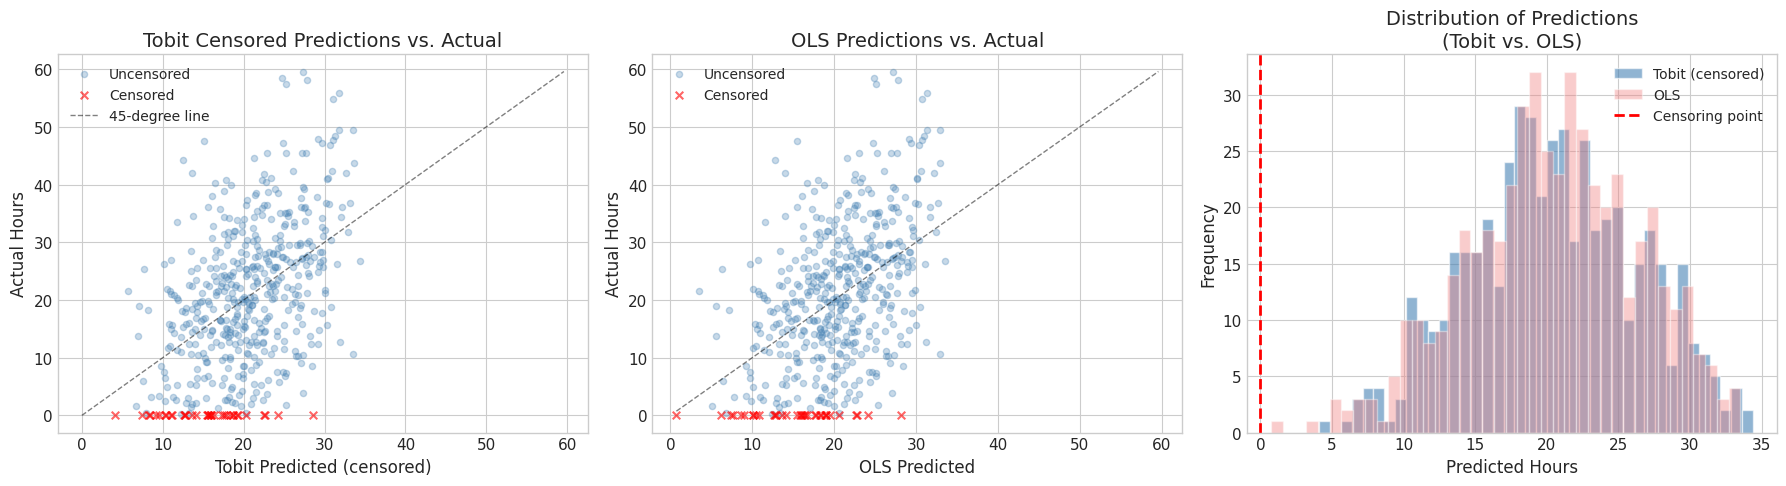

In [18]:
# Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Censored Tobit predictions vs actual
ax = axes[0]
ax.scatter(y_pred_censored[~censored], y[~censored], alpha=0.3, s=20, color='steelblue', label='Uncensored')
ax.scatter(y_pred_censored[censored], y[censored], alpha=0.6, s=30, color='red', marker='x', label='Censored')
ax.plot([0, y.max()], [0, y.max()], 'k--', linewidth=1, alpha=0.5, label='45-degree line')
ax.set_xlabel('Tobit Predicted (censored)')
ax.set_ylabel('Actual Hours')
ax.set_title('Tobit Censored Predictions vs. Actual')
ax.legend()

# Panel 2: OLS predictions vs actual (for comparison)
ax = axes[1]
ax.scatter(y_pred_ols[~censored], y[~censored], alpha=0.3, s=20, color='steelblue', label='Uncensored')
ax.scatter(y_pred_ols[censored], y[censored], alpha=0.6, s=30, color='red', marker='x', label='Censored')
ax.plot([y_pred_ols.min(), y.max()], [y_pred_ols.min(), y.max()], 'k--', linewidth=1, alpha=0.5)
ax.set_xlabel('OLS Predicted')
ax.set_ylabel('Actual Hours')
ax.set_title('OLS Predictions vs. Actual')
ax.legend()

# Panel 3: Distribution of predictions
ax = axes[2]
ax.hist(y_pred_censored, bins=40, alpha=0.6, color='steelblue', label='Tobit (censored)', edgecolor='white')
ax.hist(y_pred_ols, bins=40, alpha=0.4, color='lightcoral', label='OLS', edgecolor='white')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Censoring point')
ax.set_xlabel('Predicted Hours')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Predictions\n(Tobit vs. OLS)')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

*Figure: Prediction comparison. Left: Tobit censored predictions vs. actual hours -- predictions respect the non-negativity constraint. Center: OLS predictions vs. actual -- note the negative predicted values. Right: Distribution of predictions showing that Tobit predictions are bounded below at zero while OLS predictions can be negative.*

## 7.2 Residuals Analysis

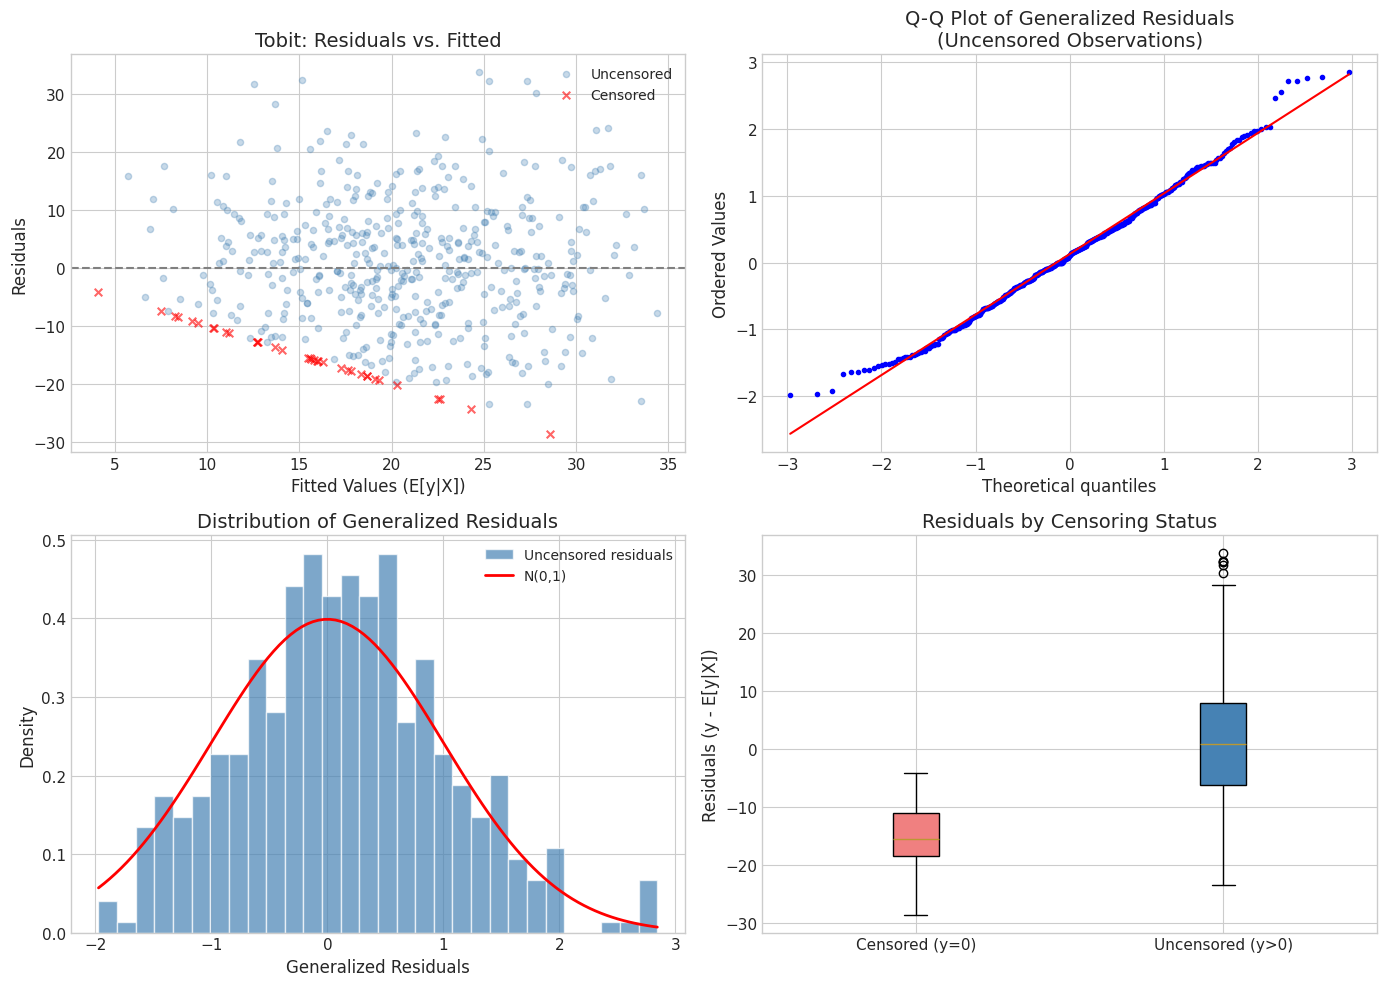

In [19]:
# Compute generalized residuals for Tobit
# For uncensored: e_i = y_i - X'beta
# For censored: generalized residual = -sigma * IMR

residuals_latent = y - y_pred_latent  # raw residuals from latent model
residuals_censored = y - y_pred_censored  # residuals from censored predictions
residuals_ols = y - y_pred_ols  # OLS residuals

# Generalized residuals (Gourieroux et al., 1987)
z = (X @ tobit_model.beta) / tobit_model.sigma
gen_residuals = np.where(
    y > 0,
    (y - X @ tobit_model.beta) / tobit_model.sigma,  # uncensored
    -stats.norm.pdf(z) / (1 - stats.norm.cdf(z) + 1e-10)  # censored: -phi(z)/(1-Phi(z))
)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Residuals vs fitted (censored predictions)
ax = axes[0, 0]
ax.scatter(y_pred_censored[~censored], residuals_censored[~censored],
           alpha=0.3, s=20, color='steelblue', label='Uncensored')
ax.scatter(y_pred_censored[censored], residuals_censored[censored],
           alpha=0.6, s=30, color='red', marker='x', label='Censored')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Fitted Values (E[y|X])')
ax.set_ylabel('Residuals')
ax.set_title('Tobit: Residuals vs. Fitted')
ax.legend()

# Panel 2: Q-Q plot of generalized residuals
ax = axes[0, 1]
stats.probplot(gen_residuals[~censored], dist='norm', plot=ax)
ax.set_title('Q-Q Plot of Generalized Residuals\n(Uncensored Observations)')
ax.get_lines()[0].set_markersize(3)

# Panel 3: Histogram of generalized residuals
ax = axes[1, 0]
ax.hist(gen_residuals[~censored], bins=30, density=True,
        color='steelblue', edgecolor='white', alpha=0.7, label='Uncensored residuals')
x_range = np.linspace(gen_residuals[~censored].min(), gen_residuals[~censored].max(), 100)
ax.plot(x_range, stats.norm.pdf(x_range, 0, 1), 'r-', linewidth=2, label='N(0,1)')
ax.set_xlabel('Generalized Residuals')
ax.set_ylabel('Density')
ax.set_title('Distribution of Generalized Residuals')
ax.legend()

# Panel 4: Residuals by censoring status
ax = axes[1, 1]
bp = ax.boxplot(
    [residuals_censored[censored], residuals_censored[~censored]],
    labels=['Censored (y=0)', 'Uncensored (y>0)'],
    patch_artist=True
)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('steelblue')
ax.set_ylabel('Residuals (y - E[y|X])')
ax.set_title('Residuals by Censoring Status')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_residual_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

*Figure: Diagnostic plots for the Tobit model. Top-left: Residuals vs. fitted values, showing the characteristic pattern for censored models. Top-right: Q-Q plot of generalized residuals for uncensored observations against the standard normal. Bottom-left: Histogram of generalized residuals overlaid with the standard normal density. Bottom-right: Boxplots comparing residual distributions for censored and uncensored observations.*

## 7.3 Probability of Censoring

We can use the Tobit model to predict the probability of censoring ($P(y = 0|\mathbf{X})$)
for each individual. This is useful for understanding which types of individuals
are most likely to be non-participants.

Predicted Probability of Participation (P(y>0|X))

Mean: 0.929
Std:  0.075
Min:  0.455
Max:  0.998

Actual participation rate: 0.930


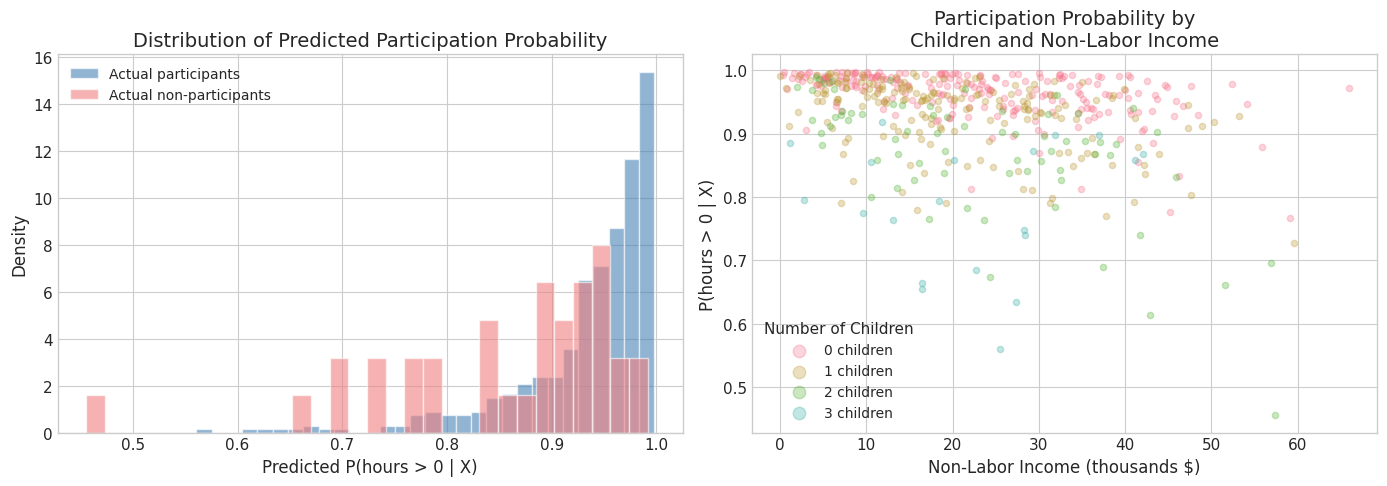

In [20]:
# Probability of censoring from the Tobit model
# P(y=0|X) = Phi((-X'beta)/sigma) = 1 - Phi(X'beta/sigma)
prob_censored = tobit_model.predict(pred_type='probability')

# Note: PooledTobit.predict(pred_type='probability') returns P(y=0|X)
# (the probability of censoring), not P(y>0|X)
prob_uncensored = 1 - prob_censored

print('=' * 60)
print('Predicted Probability of Participation (P(y>0|X))')
print('=' * 60)
print(f'\nMean: {prob_uncensored.mean():.3f}')
print(f'Std:  {prob_uncensored.std():.3f}')
print(f'Min:  {prob_uncensored.min():.3f}')
print(f'Max:  {prob_uncensored.max():.3f}')
print(f'\nActual participation rate: {(y > 0).mean():.3f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Distribution of predicted participation probabilities
ax = axes[0]
ax.hist(prob_uncensored[~censored], bins=30, alpha=0.6, color='steelblue',
        edgecolor='white', label='Actual participants', density=True)
ax.hist(prob_uncensored[censored], bins=30, alpha=0.6, color='lightcoral',
        edgecolor='white', label='Actual non-participants', density=True)
ax.set_xlabel('Predicted P(hours > 0 | X)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Predicted Participation Probability')
ax.legend()

# Panel 2: Predicted probability vs children (key variable)
ax = axes[1]
for nc in sorted(df['children'].unique()):
    mask = df['children'] == nc
    if mask.sum() > 10:
        ax.scatter(df.loc[mask, 'non_labor_income'], prob_uncensored[mask],
                   alpha=0.3, s=20, label=f'{nc} children')
ax.set_xlabel('Non-Labor Income (thousands $)')
ax.set_ylabel('P(hours > 0 | X)')
ax.set_title('Participation Probability by\nChildren and Non-Labor Income')
ax.legend(title='Number of Children', markerscale=2)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_participation_probability.png', dpi=150, bbox_inches='tight')
plt.show()

*Figure: Predicted participation probabilities from the Tobit model. Left: Distribution of predicted probabilities, separated by actual participation status -- the model correctly assigns higher participation probabilities to actual participants. Right: How participation probability varies with non-labor income and number of children.*

## 7.4 Prediction Profiles

Let us examine how the Tobit model predicts hours for different individual profiles.

In [21]:
# Prediction profiles for representative individuals
print('=' * 80)
print('Prediction Profiles for Representative Individuals')
print('=' * 80)

profiles = {
    'Young, educated, no kids': {
        'wage': 15.0, 'education': 16, 'experience': 5, 'experience_sq': 25,
        'children': 0, 'married': 0, 'non_labor_income': 5.0
    },
    'Mid-career, 2 kids': {
        'wage': 12.0, 'education': 14, 'experience': 15, 'experience_sq': 225,
        'children': 2, 'married': 1, 'non_labor_income': 25.0
    },
    'Low wage, 3 kids': {
        'wage': 5.0, 'education': 10, 'experience': 8, 'experience_sq': 64,
        'children': 3, 'married': 1, 'non_labor_income': 30.0
    },
    'High earner, married': {
        'wage': 25.0, 'education': 18, 'experience': 20, 'experience_sq': 400,
        'children': 1, 'married': 1, 'non_labor_income': 10.0
    },
}

print(f'\n{"Profile":<30} {"E[y*|X]":>10} {"E[y|X]":>10} {"P(y>0)":>10} {"OLS":>10}')
print('-' * 72)

for name, vals in profiles.items():
    x_vec = np.array([[1.0] + [vals[col] for col in feature_cols]])
    
    # Tobit predictions
    y_latent = tobit_model.predict(exog=x_vec, pred_type='latent')[0]
    y_cens = tobit_model.predict(exog=x_vec, pred_type='censored')[0]
    p_cens = tobit_model.predict(exog=x_vec, pred_type='probability')[0]
    p_uncens = 1 - p_cens
    
    # OLS prediction
    y_ols = (x_vec @ ols_full.params)[0]
    
    print(f'{name:<30} {y_latent:>10.2f} {y_cens:>10.2f} {p_uncens:>10.3f} {y_ols:>10.2f}')

Prediction Profiles for Representative Individuals

Profile                           E[y*|X]     E[y|X]     P(y>0)        OLS
------------------------------------------------------------------------
Young, educated, no kids            19.70      19.94      0.951      19.78
Mid-career, 2 kids                  16.25      16.72      0.914      16.99
Low wage, 3 kids                     2.50       6.10      0.583       4.24
High earner, married                31.08      31.10      0.996      30.62


---

# Section 8: Summary and Key Takeaways

## What You Have Learned

In this notebook, you have learned:

1. **Why censored models are needed**: OLS on censored data produces biased (attenuated) coefficients
   and can predict impossible negative values

2. **Recognizing censored data**: The hallmark is a pile-up at the censoring point in the
   distribution of the dependent variable

3. **The Tobit model**: A latent variable model where $y_i^* = \mathbf{X}_i'\boldsymbol{\beta} + \varepsilon_i$
   and $y_i = \max(0, y_i^*)$, estimated by Maximum Likelihood

4. **PanelBox estimation**: Using `PooledTobit(endog, exog, censoring_point, censoring_type).fit()`

5. **Coefficient interpretation**: Tobit $\beta$ measures the effect on the *latent* variable,
   not the observed outcome. Use marginal effects for proper interpretation

6. **McDonald-Moffitt decomposition**: Three types of marginal effects:
   - **Unconditional**: Effect on $E[y|\mathbf{X}]$ (most commonly reported)
   - **Conditional**: Effect on $E[y|y>0, \mathbf{X}]$ (among participants)
   - **Probability**: Effect on $P(y>0|\mathbf{X})$ (on participation)

7. **Predictions and diagnostics**: Latent vs. censored predictions, generalized residuals

## Key Formulas

| Quantity | Formula |
|----------|---------|
| Latent variable | $y_i^* = \mathbf{X}_i'\boldsymbol{\beta} + \varepsilon_i$ |
| Observed | $y_i = \max(0, y_i^*)$ |
| $P(y > 0 \mid \mathbf{X})$ | $\Phi(\mathbf{X}'\boldsymbol{\beta} / \sigma)$ |
| $E[y \mid \mathbf{X}]$ | $\Phi(z) \cdot \mathbf{X}'\boldsymbol{\beta} + \sigma \cdot \phi(z)$ |
| Unconditional ME | $\beta_k \cdot \Phi(z)$ |
| Conditional ME | $\beta_k [1 - \lambda(z)(z + \lambda(z))]$ |
| Probability ME | $(\beta_k / \sigma) \cdot \phi(z)$ |

where $z = \mathbf{X}'\boldsymbol{\beta}/\sigma$ and $\lambda(z) = \phi(z)/\Phi(z)$.

## Common Pitfalls

1. Interpreting Tobit $\beta$ directly as the marginal effect on the observed outcome
2. Using OLS on censored data without acknowledging the attenuation bias
3. Confusing *censoring* (the value exists but is not observed) with *truncation*
   (the observation is entirely missing from the sample)
4. Ignoring the normality assumption -- the Tobit model is sensitive to non-normality
5. Applying the Tobit model to data with genuine corner solutions (where zero is an
   optimal choice, not a constraint)

## Next Steps

### Recommended Sequence

1. **Notebook 02: Panel Tobit Models**
   - Random Effects Tobit for panel data
   - Accounting for unobserved heterogeneity
   - Gauss-Hermite quadrature for integration

2. **Notebook 03: Fixed Effects Approaches**
   - Honore Trimmed LAD estimator
   - Semiparametric methods for censored panel data

3. **Notebook 04: Heckman Selection Models**
   - When the censoring mechanism differs from the outcome
   - Two-step and full MLE estimation

## Additional Resources

### Textbooks
- **Wooldridge (2010)**: *Econometric Analysis of Cross Section and Panel Data*, Chapter 17
- **Greene (2018)**: *Econometric Analysis*, Chapter 19
- **Cameron & Trivedi (2005)**: *Microeconometrics*, Chapter 16

### Papers
- Tobin (1958): Original Tobit model paper
- McDonald & Moffitt (1980): Decomposition of marginal effects
- Amemiya (1984): Comprehensive survey of Tobit models
- Honore (1992): Fixed effects estimation for censored panel data

---

---

# Section 9: Exercises

## Exercise 1: Variable Selection (Easy)

Re-estimate the Tobit model using only `wage`, `education`, and `children` as
explanatory variables (plus a constant). Compare the coefficients and log-likelihood
with the full model. Does the restricted model fit significantly worse? Use a
likelihood ratio test:

$$LR = -2(\ln L_{\text{restricted}} - \ln L_{\text{full}}) \sim \chi^2(q)$$

where $q$ is the number of restrictions.

In [22]:
# Exercise 1: Your solution here
# Hint:
# restricted_cols = ['wage', 'education', 'children']
# X_restricted = sm.add_constant(df[restricted_cols].values)
# tobit_restricted = PooledTobit(endog=y, exog=X_restricted, censoring_point=0.0).fit()
# LR = -2 * (tobit_restricted.llf - tobit_model.llf)
# p_value = 1 - stats.chi2.cdf(LR, df=4)  # 4 restrictions

## Exercise 2: Prediction Profiles (Medium)

Create three hypothetical individual profiles that represent:
- A person very likely to work (high education, no children, low non-labor income)
- A person on the margin (moderate characteristics)
- A person unlikely to work (low education, many children, high non-labor income)

For each profile, compute:
1. The latent prediction $E[y^*|\mathbf{X}]$
2. The censored prediction $E[y|\mathbf{X}]$
3. The probability of working $P(y > 0|\mathbf{X})$
4. The conditional expected hours $E[y|y>0, \mathbf{X}]$

Verify that $E[y|\mathbf{X}] = P(y>0|\mathbf{X}) \cdot E[y|y>0, \mathbf{X}] + 0 \cdot P(y=0|\mathbf{X})$

In [23]:
# Exercise 2: Your solution here
# Hint: For the conditional mean E[y|y>0,X]:
#   z = (X'beta) / sigma
#   IMR = stats.norm.pdf(z) / stats.norm.cdf(z)
#   E[y|y>0,X] = X'beta + sigma * IMR

## Exercise 3: Right-Censoring (Medium)

Suppose weekly hours are **right-censored** at 40 (full-time workers are all recorded
as 40 hours even if they work more). Create an artificial right-censored variable:

```python
hours_right_censored = np.minimum(df['hours'], 40.0)
```

Estimate a Tobit model with `censoring_type='right'` and `censoring_point=40.0`.
Compare the estimates with OLS and the left-censored Tobit.

In [24]:
# Exercise 3: Your solution here
# Hint:
# hours_rc = np.minimum(df['hours'].values, 40.0)
# tobit_right = PooledTobit(endog=hours_rc, exog=X,
#                           censoring_point=40.0, censoring_type='right')
# tobit_right = tobit_right.fit()

## Exercise 4: Manual McDonald-Moffitt Decomposition (Hard)

Manually compute the three marginal effects for each observation using the formulas
from Section 6 and verify that they match the PanelBox output.

For each observation $i$:
1. Compute $z_i = \mathbf{X}_i'\hat{\boldsymbol{\beta}} / \hat{\sigma}$
2. Compute $\Phi(z_i)$ and $\phi(z_i)$
3. Compute the inverse Mills ratio $\lambda(z_i) = \phi(z_i)/\Phi(z_i)$
4. For each variable $k$:
   - Unconditional ME: $\hat{\beta}_k \cdot \Phi(z_i)$
   - Conditional ME: $\hat{\beta}_k \cdot [1 - \lambda(z_i)(z_i + \lambda(z_i))]$
   - Probability ME: $(\hat{\beta}_k / \hat{\sigma}) \cdot \phi(z_i)$
5. Average across all observations to get AME
6. Compare with `tobit_model.marginal_effects(at='overall', which=...)`

In [25]:
# Exercise 4: Your solution here
# Hint:
# z = (X @ tobit_model.beta) / tobit_model.sigma
# Phi_z = stats.norm.cdf(z)
# phi_z = stats.norm.pdf(z)
# lambda_z = phi_z / Phi_z  # inverse Mills ratio
#
# For variable k with coefficient beta_k:
# ME_unconditional_i = beta_k * Phi_z
# ME_conditional_i = beta_k * (1 - lambda_z * (z + lambda_z))
# ME_probability_i = (beta_k / sigma) * phi_z
#
# AME_k = np.mean(ME_i)  # average over all i

---

## Feedback

If you found errors or have suggestions for improvement, please:
- Open an issue on GitHub
- Contact the maintainers
- Contribute improvements via pull request

---

**End of Notebook 01: Introduction to Tobit Models**

You are now ready to proceed to **Notebook 02: Panel Tobit Models** or
**Notebook 04: Heckman Selection Models**.